# Predicting Hourly Traffic Density in the City of Manila Based on Weather Features

## Part I: Data Collection and Processing

Historical traffic data in the City of Manila for May 31 to June 6, 2023 was collected from tomtom.com and transcribed into a dataset.

This data consists of 7 days worth of hourly traffic data (168 rows) consisting of 3 features:

1.   Live Speed (kilometers/hour) - Formula is km-driven over travel time. The travel time and km-driven are calculated for each directed road segment (DSEG) within the city circle (s.a.) on an hourly basis.
2.   Usual Time per 10km (seconds) - Typical travel time per 10km based on TomTom historic data (from 2022). Converted from minutes and seconds format.
3.   Live Time per 10km (seconds) - Real-time measurement of traffic in the city. Shows the average time it would currently take to travel 10 km. Converted from minutes and seconds format.

(Descriptions summarized from https://www.tomtom.com/traffic-index/about/)

From our project proposal, we have changed the weather data source to https://meteostat.net/en/station/98425 as the data is recorded in hourly intervals and there is more information available. It is more reliable than the previous source because it also indentifies from which station the weather data was recorded.

The weather data for the City of Manila during the same time period was also collected and transcribed from meteostat.net. 

This data consists of 7 days worth of weather data (168 rows) consisting of 7 features:

1.   Temperature (temp) (degrees Celsius) - Air temperature taken in the area.
2.   Dew Point (dwpt) (degrees Celsius) - The dew point is the temperature the air needs to be cooled to (at constant pressure) in order to achieve a relative humidity of 100%. 
3.   Relative Humidity (rhum) (percent) - the amount of water vapor in the air, expressed as a percentage of the maximum amount of water vapor the air can hold at the same temperature.
4.   Total Precipitation (prcp) (millimeters) - The amount of water (rain, snow, etc.) that falls to the surface.
5.   Snow Depth (snow) - Irrelevant to this study, as it does not snow in Manila.
6.   Wind Direction (wdir) (degrees) - The true direction from which the wind is blowing at a given location (i.e., wind blowing from the north to the south is a north wind). It is normally measured in tens of degrees from 10 degrees clockwise through 360 degrees. North is 360 degrees. A wind direction of 0 degrees is only used when wind is calm.
7.   Average Wind Speed (wspd) (kilometers/hour) - The rate at which air is moving horizontally past a given point.
8.   Wind Peak Gust (wpgt) (kilometers/hour) - The highest instantaneous wind speed observed or recorded.
9.   Sea-Level Air Pressure (pres) (hectopascal) - Air pressure reading, converted to a value that would be observed if that instrument were located at sea level.
10.   Total Sunshine Duration (tsun) (minutes) - How much sunshine is recorded during the period.
11.   Weather Condition Code (coco) - Numerical code from 1-27 representing the type of weather recorded.

(Source for feature names and units: https://dev.meteostat.net/formats.html#meteorological-parameters) 

(Descriptions from: https://dev.meteostat.net/formats.html#meteorological-parameters, https://www.weather.gov/arx/why_dewpoint_vs_humidity, https://education.nationalgeographic.org/resource/humidity/, https://education.nationalgeographic.org/resource/precipitation/, https://forecast.weather.gov/glossary, https://www.noaa.gov/jetstream/atmosphere/air-pressure)

There are also 2 unnamed features that are shared between the datasets:

1.   Time - the 24 hour hh:mm format of the hour the measurements were taken
2.   Date - the mm/dd/yyyy format of what day the data was taken

For this project, we are concerned with these features: Live Speed (which we are trying to predict), Temperature, Dew Point, Relative Humidity, Total Precipitation, Average Wind Speed, Sea-Level Air Pressure, and Time. 

We will scale the data using MinMaxScaler to get data in the range [0, 1].

In [ ]:
# importing dependencies
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

def timeToHour(times):
    hours = []
    for i in times:
        temp = i.split(":")
        hour = int(temp[0])
        hours.append(hour)
    return hours

# read data from provided csv files
df_traffic = pd.read_csv("180_traffic_data.csv")
df_weather = pd.read_csv("180_weather_data.csv")

# create new row using function to change 24 hour hh:mm format to number of hours since 12 AM (0:00)
df_weather['hour'] = timeToHour(df_traffic['Unnamed: 1'])

# drop unnecessary axes from data (residual transcription data from the traffic dataset, unrecorded features and numerical weather code from the weather dataset)
df_traffic = df_traffic["Live speed (km/h)"]
df_weather = df_weather.drop(["time", "snow", "wpgt", "wdir", "tsun", "coco"], axis = 1)

print(df_weather)

#check if the data set has null values
print("Number of Null Values:", df_weather.isna().sum().sum())

# we will need this for the unscaled application
df_orig_weather = df_weather

# scale data values
df_weather = scaler.fit_transform(df_weather)

# split data into train and test sets, for this project we have seven days of training data (168 hours) and are trying to predict the 24 hours of data after that.
X_train = pd.DataFrame(df_weather).iloc[:168,]
y_train = pd.DataFrame(df_traffic).iloc[:168,]

X_test = pd.DataFrame(df_weather).iloc[168:,]
y_test = pd.DataFrame(df_traffic).iloc[168:,]


     temp  dwpt  rhum  prcp  wspd    pres  hour
0    29.2  25.0    78   0.2  16.7  1003.8     0
1    29.0  25.2    80   0.0  16.7  1003.3     1
2    28.8  25.2    81   0.2  16.7  1002.8     2
3    28.9  25.3    81   0.2  16.7  1002.7     3
4    29.1  25.3    80   0.0  16.7  1002.6     4
..    ...   ...   ...   ...   ...     ...   ...
187  29.1  25.5    81   0.0   7.4  1009.3    19
188  28.7  25.3    82   0.0   7.4  1009.7    20
189  28.4  25.4    84   0.0   7.4  1010.0    21
190  28.2  25.2    84   0.0   5.5  1010.3    22
191  28.0  25.2    85   0.0   5.5  1010.6    23

[192 rows x 7 columns]


Next, we'll be plotting each features of the data frame against the time difference to see if there's a correlation between each of the features against the live speed.

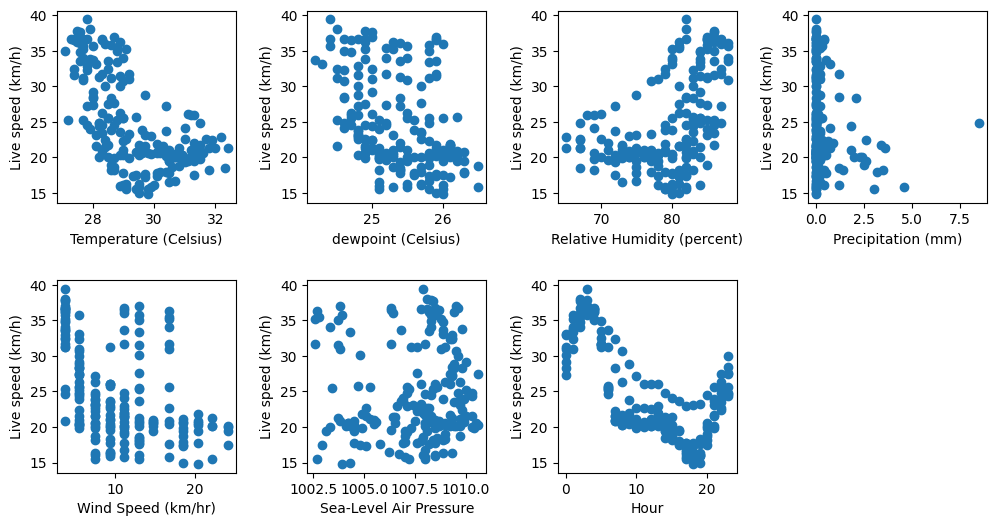

In [ ]:
# import dependencies
import matplotlib.pyplot as plt

features = ["Temperature (Celsius)", "dewpoint (Celsius)", "Relative Humidity (percent)", "Precipitation (mm)", "Wind Speed (km/hr)", "Sea-Level Air Pressure", "Hour"]
# plot each feature against live speed (km/h) to see the correlation
fig = plt.figure(figsize = (12, 6))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i in range(7):
  ax = fig.add_subplot(2, 4, i + 1)
  ax.scatter(df_orig_weather[df_orig_weather.columns[i]], df_traffic)
  ax.set_xlabel(features[i])
  ax.set_ylabel("Live speed (km/h)")

## Part II: Training and Testing Model

To start, we will be using Polynomial Regression as we believe that a curve fitting model would be able to predict the results better. We'll be training the Polynomial Regression model in varying degrees (1 to 4) and save each score to see which degree is most optimal to use.

In [ ]:
# import libraries
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

degrees = list(range(1, 5))
scores = []
scores_test = []

for i in degrees:
    regress = PolynomialFeatures(i) # polynomial regression
    # transform the training data
    poly_features = regress.fit_transform(X_train)

    # linear regressor 
    poly_reg = LinearRegression()

    # fit the polynomial model into the regressor
    poly_reg.fit(poly_features, y_train) 

    # predict training data
    y_predicted = poly_reg.predict(poly_features)

    # regression score of the model
    score = poly_reg.score(poly_features, y_train)
    scores.append(score)

    # predict test data
    y_test_predicted = poly_reg.predict(regress.fit_transform(X_test))

    # regression score of the model (test data)
    score_test = poly_reg.score(regress.fit_transform(X_test), y_test)
    scores_test.append(score_test)
    
    print(i, "degree model ")
    print("Training R2:", score)
    print("Testing R2:", score_test)

1 degree model 
Training R2: 0.7669319627837843
Testing R2: 0.726150858769653
2 degree model 
Training R2: 0.25016748629948404
Testing R2: -0.31517765800352127
3 degree model 
Training R2: 0.9588344423144454
Testing R2: -0.0574657781275123
4 degree model 
Training R2: 1.0
Testing R2: -1.3396817355504038


## Part III: Results

Regression score of Polynomial Regression with degree 1 (Train Data): 0.7669319627837843
Regression score of Polynomial Regression with degree 1 (Test Data): 0.726150858769653


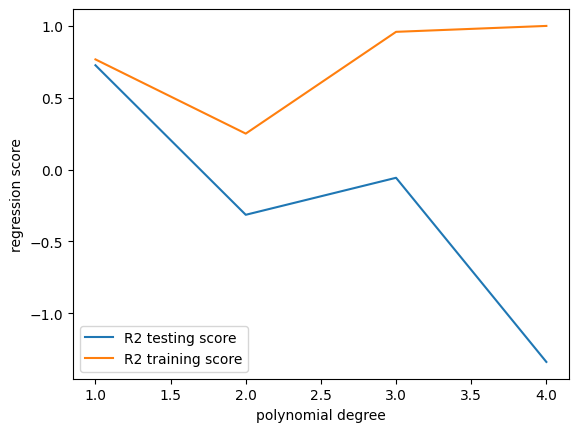

In [ ]:
# plotting each regression score from degree 1 to 4 to see which is the most optimal degree to use
fig, ax = plt.subplots()
plt.plot(degrees, scores_test, label = "R2 testing score")
plt.plot(degrees, scores, label = "R2 training score")
ax.set_xlabel("polynomial degree")
ax.set_ylabel("regression score")
ax.legend()

# choosing degree 1 (linear) since it is the most optimal to use
print("Regression score of Polynomial Regression with degree 1 (Train Data):", scores[0])
print("Regression score of Polynomial Regression with degree 1 (Test Data):", scores_test[0])

The figure above shows a plot of the polynomial degrees tried in the model against their corresponding regression scores. As shown in the figure, the regression score is highest when the model is a linear one. The more degrees present, the lower the R2 is in testing, seemingly due to overfitting.

As seen in the regression score, there is a relationship between weather features, and the speed in traffic. This could be due to weather conditions causing people to drive slower, such as slowing down due to low visibility on the road. However, there is a argument to be made that the time is the most significant feature of the data because there are hours where much more people are on the road due to work, school, and other commitments.

To check this, we made will make a model only using the Time feature and see how accurate it is.


In [ ]:
# import dependencies
import numpy as np
from sklearn.metrics import r2_score

# split data into train and test sets, but the only value in X is time

X_train1 = pd.DataFrame(df_orig_weather).iloc[:168, -1]
y_train1 = pd.DataFrame(df_traffic).iloc[:168,]

X_test1 = pd.DataFrame(df_orig_weather).iloc[168:, -1]
y_test1 = pd.DataFrame(df_traffic).iloc[168:,]

# get best fit line and use it to predict live speed
line = np.polyfit(X_train1, y_train1, 1)
tAccuracy = r2_score(y_test1, np.polyval(line, X_test1))

print("R2 score of model:", tAccuracy)

R2 score of model: 0.42362182544118177


As shown by the R2 scores of the new model, just using the time to predict the live is not effective, having an R2 score less than 43%. While it is a significant predictor of traffic, it is not the total cause. We therefore accept that the weather features presented are significant to the speed in traffic in Manila.

Our model can be used to predict the speed of traffic given these weather conditions and therefore predict the time it takes to travel a certain distance in these conditions. We start with predicting the live speed, and then multiplying its reciprocal to the distance that must be travelled. The output is how long (in hours) it takes. This is useful for people to plan their trips and make sure they arrive on time.


## Part IV: Application

In [ ]:
# get inputs
print("Check the weather forcast for this hour! https://meteostat.net/en/station/98425")
temp = float(input("Enter Temperature (in Celsius): "))
dwpt = float(input("Enter Dew Point (in Celsius): "))
rhum = float(input("Enter Relative Humidity (ex: 24% is 24): "))
prcp = float(input("Enter Expected Precipitation (in mm): "))
wspd = float(input("Enter Wind Speed (in km/h): "))
pres = float(input("Enter Air Pressure at Sea Level (in hectopascal/millibar): "))
time = input("Enter Time in 24 hour format (e.g. 5PM is 17:00): ")

hour = timeToHour([time])[0]

distance = float(input("How far do you have to travel (in km)?"))

# create new feature dataframe using inputs
s1 = [temp, dwpt, rhum, prcp, wspd, pres, hour]
new = pd.DataFrame([s1], columns = ["temp", "dwpt", "rhum", "prcp", "wspd", "pres", "hour"])

X = df_orig_weather
y = df_traffic

# perform linear regression using all data (including testing data)
applied = LinearRegression()
applied.fit(X, y)

speed_pred = applied.predict(new)
time_pred = (distance/speed_pred)[0]
time_pred_min = time_pred*60

out_hours = "%.2f" % time_pred
out_mins = "%.0f" % time_pred_min

print("According to our model, it will take", out_hours, "hours or", out_mins, "minutes to get to your destination.")
print("\n\nDISCLAIMER: \nThis is only an estimate and it is possible to get to your destination earlier or later than usual due to factors that our model wasn't trained on (Rush hours, Unforeseen circumstances, Accidents, Road work, etc).")

Check the weather forcast for this hour! https://meteostat.net/en/station/98425
Enter Temperature (in Celsius): 30
Enter Dew Point (in Celsius): 25.5
Enter Relative Humidity (ex: 24% is 24): 77
Enter Expected Precipitation (in mm): 0.4
Enter Wind Speed (in km/h): 16.7
Enter Air Pressure at Sea Level (in hectopascal/millibar): 1005
Enter Time in 24 hour format (e.g. 5PM is 17:00): 14:00
How far do you have to travel (in km)?10
According to our model, it will take 0.44 hours or 26 minutes to get to your destination.


DISCLAIMER: 
This is only an estimate and it is possible to get to your destination earlier or later than usual due to factors that our model wasn't trained on (Rush hours, Unforeseen circumstances, Accidents, Road work).
